# Initial Setup

In [3]:
!pip install krippendorff

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
%load_ext autoreload
%autoreload 2

import sys
from google.colab import drive
import pandas as pd
import numpy as np
import torch
from tqdm.notebook import tqdm
from  nltk.metrics import agreement
import krippendorff
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import table

GDRIVE_BASE = 'drive/MyDrive/MIDS/w266/project/'
# ANNOTATOR='nico'
# ANNOTATOR='ghiwa'
ANNOTATOR='ram'

drive.mount('/content/drive')
sys.path.insert(0, GDRIVE_BASE)


Mounted at /content/drive


# Manual Annotation
This notebook is for running the manual annotation. It supports two activities:
-  Identifying the best response in each batch of generated text.
- Annotating the best response, as identified by the model, from each batch.
- Annotating the best response, as identified manually in the above step from each batch.

The first step of manually identifying the best response should be done just once by one person while the next step should be done individually by each annotator. Before getting started, ensure that the annotator name is set correctly.

Pre-requisites:
- The annotation input file, generated through the inferencing.ipynb notebook, must be available in GDRIVE_BASE location.


## Best in Batch

In [ ]:
BIB_IN_FILE = f'{GDRIVE_BASE}manual_eval_generated_output.csv'
BIB_OUT_FILE = f'{GDRIVE_BASE}manual_eval_generated_output_with_bib.csv'

def is_completed(batch):
  return len(batch[batch.human_top_score == True]) > 0

def mark_best(ignore_completed=False, save_each_step=True):
  # Load the annotation input
  if ignore_completed:
    # Load from prevously saved work.
    df_results = pd.read_csv(BIB_OUT_FILE)
  else:
    # Load from the original annotation input.
    df_results = pd.read_csv(BIB_IN_FILE)
    # Add a new column to hold the best in batch flag.
    df_results['human_top_score'] = False
  df_results.generated = df_results.generated.fillna('')
  num_batches = df_results.batch_id.max()
  batch_size = int(df_results.shape[0] / num_batches)

  # Random order of batches.
  batch_ids = np.arange(num_batches)
  np.random.shuffle(batch_ids)
  with tqdm(total=num_batches, unit='item', unit_scale=True) as pbar:
    for cur_batch_id in batch_ids:
      # Adjust for batch ids starting from 1.
      cur_batch_id = cur_batch_id + 1
      batch = df_results[df_results.batch_id == cur_batch_id]
      if len(batch) != batch_size:
        # We should never get here something is wrong.
        raise Exception(f'Batch {cur_batch_id} has {len(batch)} items but expecting {batch_size} items.')
      if is_completed(batch):
        print(f'Skipping batch {cur_batch_id} as it is already completed.')
      else:
        cur_prompt = batch.prompt.iloc[0]
        pbar.set_postfix(batch_id=cur_batch_id, prompt=cur_prompt[0:10] + '...', refresh=True)
        # Display the batch and get user's choice pick the best.
        indices = {}
        print(f'PROMPT: {cur_prompt}')
        i = 1
        for index, row in batch.iterrows():
          cur_generated = row["generated"] #.replace(cur_prompt + ' ', '')
          print(f'{i}. {cur_generated}')
          indices[i] = index
          i = i+1
        
        user_opt = -1
        msg = f'Enter 1 to {batch_size} or "quit"'
        quit = False
        while user_opt == -1:
          try:
            user_input = input(f'{msg}: ')
            if user_input == 'quit':
              quit = True
              break
            user_opt = int(user_input)
            if user_opt in indices:
              df_results.loc[indices[user_opt],'human_top_score'] = True
              if save_each_step:
                df_results.to_csv(BIB_OUT_FILE, index=None)
            else:
              print(msg)
              user_opt = -1
          except ValueError:
            print(msg)
            user_opt = -1      
        pbar.update(1)
        if quit:
          break
    df_results.to_csv(BIB_OUT_FILE, index=None)

In [ ]:
# Run this cell to start an interactive session to identify best generated text in each batch.
# This will walk through the batches randomly and present one batch at a time. 
# A batch is defined as the N (currently N=5) texts generated from one model configuration for one prompt.
# For each batch shown, select the best text. The method creates a new file with the final result.
# Set ignore_completed to True if continuing from a previous session.
# save_each_step=True ensures that the dataframe is saved after each batch is marked.
mark_best(ignore_completed=True, save_each_step=True)

  0%|          | 0.00/120 [00:00<?, ?item/s]

Skipping batch 44 as it is already completed.
Skipping batch 93 as it is already completed.
Skipping batch 48 as it is already completed.
Skipping batch 80 as it is already completed.
Skipping batch 57 as it is already completed.
Skipping batch 103 as it is already completed.
Skipping batch 11 as it is already completed.
Skipping batch 28 as it is already completed.
Skipping batch 13 as it is already completed.
Skipping batch 110 as it is already completed.
Skipping batch 89 as it is already completed.
Skipping batch 102 as it is already completed.
Skipping batch 27 as it is already completed.
Skipping batch 100 as it is already completed.
Skipping batch 26 as it is already completed.
Skipping batch 19 as it is already completed.
Skipping batch 74 as it is already completed.
Skipping batch 22 as it is already completed.
Skipping batch 77 as it is already completed.
Skipping batch 71 as it is already completed.
Skipping batch 88 as it is already completed.
Skipping batch 8 as it is alre

In [ ]:
# Show the final results with best of batch marked.
df_results = pd.read_csv(BIB_OUT_FILE)
print(f'BIB annotation completed for {df_results[df_results.human_top_score == True].shape[0]} of {df_results.batch_id.max()} entries.')
df_results

BIB annotation completed for 119 of 120 entries.


,batch_id,name,model,tuned,dataset,prompt,score,generated,model_top_score,human_top_score
0,1,t5_s3,t5-v1_1-base-s3-finetuned,True,s3,"My stomach did a flip, then a flop, I couldn't...",0.000084,"I thought of the money, but then I saw another...",False,False
1,1,t5_s3,t5-v1_1-base-s3-finetuned,True,s3,"My stomach did a flip, then a flop, I couldn't...",0.000063,"""Come here, come here!"" cried John.",False,True
2,1,t5_s3,t5-v1_1-base-s3-finetuned,True,s3,"My stomach did a flip, then a flop, I couldn't...",0.000060,"I went to the hole and looked at it, and drew ...",False,False
3,1,t5_s3,t5-v1_1-base-s3-finetuned,True,s3,"My stomach did a flip, then a flop, I couldn't...",0.000096,I sprang back in the water and threw my hands ...,False,False
4,1,t5_s3,t5-v1_1-base-s3-finetuned,True,s3,"My stomach did a flip, then a flop, I couldn't...",0.000183,I sat up and looked.,True,False
...,...,...,...,...,...,...,...,...,...,...
595,120,baseline,facebook/opt-350m,False,NaN,Do you think my mom will let me have pizza for...,0.017286,Do you think my mom will let me have pizza for...,False,False
596,120,baseline,facebook/opt-350m,False,NaN,Do you think my mom will let me have pizza for...,0.030708,Do you think my mom will let me have pizza for...,True,False
597,120,baseline,facebook/opt-350m,False,NaN,Do you think my mom will let me have pizza for...,0.017263,Do you think my mom will let me have pizza for...,False,False
598,120,baseline,facebook/opt-350m,False,NaN,Do you think my mom will let me have pizza for...,0.026418,Do you think my mom will let me have pizza for...,False,True


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


## Bug Fixes

In [ ]:
# Update annotated file with results from models that were excluded during annotation
PRE_ANNOTATION_FILE = f'{GDRIVE_BASE}manual_eval_generated_output_with_bib.csv'
POST_ANNOTATION_FILE = f'{GDRIVE_BASE}{ANNOTATOR}_final_annotations.csv'
# Backup file name. The script will first create a backup of the annotated file before overwriting it.
POST_ANNOTATION_FILE_BACK = f'{GDRIVE_BASE}{ANNOTATOR}_final_annotations_test_backup.csv'
import shutil

def is_match(cur_gen_id, pre_row, post_row):
  def is_col_match(col_name):
    is_match = (pre_row[col_name] == post_row[col_name])
    return is_match
  matching = is_col_match('name') and is_col_match('generated') and is_col_match('prompt') and \
      is_col_match('model_top_score') and is_col_match('human_top_score')
  if not matching:
    print('================Pre================')
    print(pre_row)
    print('================Post================')
    print(post_row)
  return matching

def bug_fix_1():
  # 
  # Read the pre-annotation file.
  df_pre = pd.read_csv(PRE_ANNOTATION_FILE)
  # Add the annotation related cols with defaults
  df_pre['gen_id'] = df_pre.index 
  df_pre['annotated'] = False
  for metric in METRICS:
    df_pre[metric] = -1

  # Iterate through post annotation file and update pre with the data.
  df_post = pd.read_csv(POST_ANNOTATION_FILE)
  for index, post_row in df_post.iterrows():
    cur_gen_id = post_row.gen_id
    pre_row = df_pre.loc[cur_gen_id]
    if not is_match(cur_gen_id, pre_row, post_row):
      raise Exception(f'Rows at {cur_gen_id} are not matching.')
    else:
      df_pre.loc[cur_gen_id, 'annotated'] = post_row['annotated']
      for metric in METRICS:
        df_pre.loc[cur_gen_id, metric] = post_row[metric]
  
  # Backup old data before overwriting.
  shutil.copyfile(POST_ANNOTATION_FILE, POST_ANNOTATION_FILE_BACK)
  df_post.to_csv(POST_ANNOTATION_FILE_BACK, index=None)
  df_pre.to_csv(POST_ANNOTATION_FILE, index=None)
  return df_pre


In [ ]:
# Un comment the below line to run the fix for missing t5_s3, opt_s3 and b2b_s3 models
# during annotation.
# bug_fix_1()

## Manual Scoring Of Results

In [ ]:
MA_IN_FILE=f'{GDRIVE_BASE}manual_eval_generated_output_with_bib.csv'
MA_OUT_FILE=f'{GDRIVE_BASE}{ANNOTATOR}_final_annotations.csv'
METRICS = [
    'relevance',
    'readability',
    'grammaticality',
    'non-redundancy',
    'kid-friendly']
SCALES = [
    ('outstanding', 7),
    ('very good', 6),
    ('good', 5),
    ('neutral', 4),
    ('bad', 3),
    ('very bad', 2),
    ('unusable', 1)]

def load_data(in_file, out_file, ignore_completed):
  if ignore_completed:
    df_data = pd.read_csv(out_file)
  else:
    df_data = pd.read_csv(in_file)
    # Add the extra cols for annotation.
    df_data['gen_id'] = df_data.index # Explicit id columns as we want to retain 
                                      # the original indices even after filtering.
    df_data['annotated'] = False
    for metric in METRICS:
      df_data[metric] = -1
  df_data.generated = df_data.generated.fillna('')

  # Columns: 'batch_id', 'name', 'model', 'tuned', 'dataset', 'prompt', 'score', 'generated', 'model_top_score', 'human_top_score'
  # Pick only entries from models trained on S3 dataset and also only the 
  # top entries - one of model_top_score, human_top_score is True.
  df_filtered = df_data[((df_data.dataset == 's3') | (df_data.name == 'baseline')) & ((df_data.model_top_score) | (df_data.human_top_score))]
  # df_filtered = df_data[(df_data.name == 'baseline') & ((df_data.model_top_score) | (df_data.human_top_score))]
  return df_filtered

def annotate_one(cur_index, cur_row):
  msg = f"Enter one of {', '.join([f'{scale}({score})' for scale, score in SCALES])}"
  scores = {}
  print(msg)
  quit = False
  # Initialize the map with -1 scores.
  for metric in METRICS:
    scores[metric] = -1
  for metric in METRICS:
    # Get score for current metric.
    print(f'\tScore generated text for {metric}: ')
    quit = False
    user_opt = -1
    while user_opt == -1:
      try:
        user_input = input(f'Your score (or "quit"): ')
        if user_input == 'quit':
          quit = True
          return quit, scores
        user_opt = int(user_input)
        if user_opt >= 1 and  user_opt <= 7:
          scores[metric] = user_opt
        else:
          print(f'Invalid entry. Please {msg}')
          user_opt = -1
      except ValueError:
        print(msg)
        user_opt = -1
  return quit, scores

def print_progress(df_data):
  num_entries = df_data.shape[0]
  num_annotated = df_data[df_data.annotated].shape[0]
  print(f'Progress: Annotated {num_annotated} out of {num_entries} entries.')

def annotate(annotator, in_file, out_file, ignore_completed=False, save_each_step=True):
  df_data = load_data(in_file, out_file, ignore_completed)
  # Random order of items.
  indices = df_data.index.values.copy()
  np.random.shuffle(indices)
  print(f'Score scale: ')
  with tqdm(total=indices.shape[0], unit='item', unit_scale=True) as pbar:
    print_progress(df_data)
    pbar.update(df_data[df_data.annotated].shape[0])
    for cur_index in indices:
      cur_row = df_data.loc[cur_index]
      cur_prompt = cur_row['prompt']
      cur_generated = cur_row['generated']
      cur_generated = cur_generated.replace(cur_prompt + ' ', '')
      if not (ignore_completed and cur_row['annotated']):
        # Display the prompt and the generated text.
        pbar.set_postfix(index=cur_row['gen_id'], prompt=cur_prompt[0:10] + '...', generated=cur_generated[0:10] + '...', refresh=True)
        print('='*50)
        print(f'PROMPT: {cur_prompt}')
        print(f'GENERATED: {cur_generated}')
        quit, scores = annotate_one(cur_index, cur_row)
        if quit:
          break
        pbar.update(1)
        df_data.loc[cur_index, 'annotated'] = True
        for metric in METRICS:
          df_data.loc[cur_index, metric] = scores[metric]
        if save_each_step:
          df_data.to_csv(out_file, index=None)
    print_progress(df_data)
    df_data.to_csv(out_file, index=None)

In [ ]:
# Ensure that the follwing variables are set correctly:
#   ANNOTATOR - name of the annotator
#   MA_IN_FILE - must be the file created through the "Best In Batch" section above.
#   MA_OUT_FILE - output file that will hold annotations. (Please keep the annotator name in the filename).
# Run this cell to start an interactive session to annotate each generated text.
# This will walk through the generated texts randomly and present one text at a time. 
# It will prompt you to evaluate on one metric at a time. Each metric is evaluated on a scale of 1 to 7 with 1 being "Unusable" and 7 being "Outstanding".
# You can quit any time by entering "quit" at a prompt. Partial scores will be ignored if you enter quit. 
# If you want to restart from where you left off then set ignore_completed to True.
# Ensure that save_each_step=True so that no data is lost.
# Finally the process saves annotations in a file specific to ANNOTATOR.

annotate(ANNOTATOR, MA_IN_FILE, MA_OUT_FILE, ignore_completed=True, save_each_step=True)

Score scale: 


  0%|          | 0.00/216 [00:00<?, ?item/s]

Progress: Annotated 213 out of 216 entries.
PROMPT: I have no idea how to start a story.
GENERATED: 
Enter one of outstanding(7), very good(6), good(5), neutral(4), bad(3), very bad(2), unusable(1)
	Score generated text for relevance: 
Your score (or "quit"): 1
	Score generated text for readability: 
Your score (or "quit"): 1
	Score generated text for grammaticality: 
Your score (or "quit"): 
Enter one of outstanding(7), very good(6), good(5), neutral(4), bad(3), very bad(2), unusable(1)
Your score (or "quit"): 1
	Score generated text for non-redundancy: 
Your score (or "quit"): 1
	Score generated text for kid-friendly: 
Your score (or "quit"): 1
PROMPT: "There's no going back now Mr. Brandon, what should we do?" Penny asked desperately.
GENERATED: 
Enter one of outstanding(7), very good(6), good(5), neutral(4), bad(3), very bad(2), unusable(1)
	Score generated text for relevance: 
Your score (or "quit"): 1
	Score generated text for readability: 
Your score (or "quit"): 1
	Score genera

# Final Analysis
## Helper Methods
This section has helper methods for anlayzing scores from auto evaluations as well as manual evaluation. It also includes methods for calculating Inter Annotator Agreement score.

In [93]:
# Helpers for loading annotation data.
ANNOTATORS = ['ghiwa', 'nico', 'ram']
ANNOTATION_FILE_FORMAT = '{}{}_final_annotations.csv' # Needs GDRIVE_BASE and annotator.
AUTO_SCORES_FILE_FORMAT = '{}final_scores.csv' # Needs GDRIVE_BASE and annotator.

MODELS = {
    't5_s3': 'T5',
    'opt_s3': 'OPT',
    'b2b_s3': 'B2B',
    'baseline': 'Baseline'}
METRICS = [
    'relevance',
    'readability',
    'grammaticality',
    'non-redundancy',
    'kid-friendly']
SCALES = [
    ('outstanding', 7),
    ('very good', 6),
    ('good', 5),
    ('neutral', 4),
    ('bad', 3),
    ('very bad', 2),
    ('unusable', 1)]

COL_ALIASES = {
    'model': 'Model',
    'relevance': 'Relevant',
    'readability': 'Readable',
    'grammaticality': 'Grammar',
    'non-redundancy': 'No Dups',
    'kid-friendly': 'Language',
    'average_score': 'Overall',
    'friendly_model': 'Model',
    'global': 'Overall',
}
NUMERIC_COLS = ['relevance', 'readability', 'grammaticality', 'non-redundancy', 'kid-friendly', 'average_score']
styles = [dict(selector="caption",
                       props=[("text-align", "center"),
                              ("caption-side", "top"),
                              ("font-size", "130%"),
                              ("color", 'black')])]

def add_friendly_model_name(df, col_name='friendly_model'):
  """Helper to add a display friendly model name to the dataset"""
  conditions = [df['name'] == model for model in MODELS.keys()]
  outputs = [MODELS[model] for model in MODELS.keys()]
  df[col_name] = np.select(conditions, outputs, None)
  return df

def load_annotations(annotators, rename=False, human_top_score=None, annotations_as_cols=False):
  def add_average_score_across_metrics(df, annotator):
    """Add a new column with average score across the 5 metrics for each row"""
    if annotations_as_cols:
      df[f'{annotator}_average_score'] = df[[f'{annotator}_{metric}' for metric in METRICS]].mean(axis=1)
    else:
      df['average_score'] = df[METRICS].mean(axis=1)
    return df

  def load_one(annotator, annotations_as_cols=False, alias=None):
    """Helper to load annotations from one annotator"""
    file = ANNOTATION_FILE_FORMAT.format(GDRIVE_BASE, annotator)
    df_cur = pd.read_csv(file)
    df_cur = df_cur[df_cur.annotated==True]
    ann_name = alias if rename else annotator
    if not annotations_as_cols:
      df_cur['annotator'] = ann_name

    return df_cur

  def load_for(real_name, name_to_use):
    df_cur = load_one(real_name, alias=name_to_use if rename else None, annotations_as_cols=annotations_as_cols)    
    if annotations_as_cols:
      df_cur.columns = [f'{name_to_use}_{col}' if col in METRICS else col for col in df_cur.columns]
    df_cur = add_average_score_across_metrics(df_cur, name_to_use)
    return df_cur

  # Load and combine annotations from all annotators.
  df_annotations = load_for(annotators[0], 'A1' if rename else annotators[0])
  size = len(df_annotations)
  for i in range(1, len(annotators)):
    name_to_use = f'A{i+1}' if rename else annotators[i]
    df_cur = load_for(annotators[i], name_to_use)
    if size != len(df_cur):
      raise Exception(f'Size mismatch while reading data for {annotators[i]}')
    if annotations_as_cols:
      for metric in METRICS:
        df_annotations[f'{name_to_use}_{metric}'] = df_cur[f'{name_to_use}_{metric}']
      df_annotations[f'{name_to_use}_average_score'] = df_cur[f'{name_to_use}_average_score']
    else:
      df_annotations = pd.concat([df_annotations, df_cur])


  # Filter for human selected or model selected generations, if speficied.
  if human_top_score is not None:
    if human_top_score:
      df_annotations = df_annotations[df_annotations.human_top_score]
    else:
      df_annotations = df_annotations[df_annotations.model_top_score]

  # Add a new column with display friendly model name
  df_annotations = add_friendly_model_name(df_annotations)
  return df_annotations

In [94]:
# Helpers for calculating inter-annotator agreement score.
# We use Krippendorff alpha score.
def aggregated_scores_for_k_alpha(annotations, human_top_score, model, metric):
  if human_top_score:
    df_filtered = annotations[(annotations.human_top_score == True)]
  else:
    df_filtered = annotations[(annotations.model_top_score == True)]
  
  if model is not None:
    df_filtered = df_filtered[(df_filtered.name == model)]

  if metric is None:
    scores = []
    for metric in METRICS:
      scores.extend(list(df_filtered[[metric]].values.flat))
    return scores
  else:
    return list(df_filtered[[metric]].values.flat)

def k_alpha_for(annotations, human_top_score, model, metric):
    scores = [aggregated_scores_for_k_alpha(annotations[(annotations.annotator==annotator)], 
                                        human_top_score, model=model, 
                                        metric=metric) for annotator in ANNOTATORS]
    if len(scores) == 0:
      print(f'Error scoring for human_top_score:{human_top_score}, model:{model}, metric:{metric}. 0 scores found.')
      print(scores)
    return krippendorff.alpha(reliability_data=scores, level_of_measurement='ordinal')

def k_alpha(annotations):
  def helper(annotations, human_top_score, model, per_metric, across_metrics):
    metric_row = {
        'Model': 'All' if model is None else MODELS[model],
        'model_selected': not human_top_score,
        'human_selected': human_top_score
    }

    if per_metric:
      for metric in METRICS:
        # Get scores for model selected result
        k_score = k_alpha_for(annotations, human_top_score=human_top_score, model=model, metric=metric)
        metric_row[COL_ALIASES[metric]] = k_score
    if across_metrics:
      k_score = k_alpha_for(annotations, human_top_score=human_top_score, model=model, metric=None)
      metric_row['Overall'] = k_score
    return metric_row  

  k_scores = []
  for model in MODELS.keys():
    k_scores.append(helper(annotations, human_top_score=False, model=model, per_metric=True, across_metrics=True))
    k_scores.append(helper(annotations, human_top_score=True, model=model, per_metric=True, across_metrics=True))

  # Metric level
  k_scores.append(helper(annotations, human_top_score=False, model=None, per_metric=True, across_metrics=True))
  k_scores.append(helper(annotations, human_top_score=True, model=None, per_metric=True, across_metrics=True))
  return pd.DataFrame(k_scores)

# def score_all():
#   # Load annotations of all annotators.
#   annotations = load_annotations(ANNOTATORS)

#   # Calculate the Inter-Annotator Agreement score
#   alpha_scores = krippendorff_scores(annotations)
  
#   # Save all generated scores.
#   df_scores = pd.DataFrame(alpha_scores)
#   return df_scores


In [86]:
# Calculate inter annotator agreement score (Krippendorff alpha)
def display_k_alpha(human_top_score):
  def highlight_max(s, props=''):
      return np.where(s == np.nanmax(s.values), props, '')

  def highlight_min(s, props=''):
      return np.where(s == np.nanmin(s.values), props, '')

  def pretty_table(styler):
    # styler.set_caption('Result of Manual Evaluation')
    styler.hide(axis="index")
    styler.set_table_styles(styles)
    styler.format(precision=4)
    # styler.background_gradient(axis=None, vmin=-0.2, vmax=0.3, cmap="PiYG")
    styler.background_gradient(axis=None, vmin=-0.2, vmax=0.3, cmap="RdYlGn")
    return styler

  df = k_alpha(load_annotations(ANNOTATORS, human_top_score=human_top_score))
  df = df[df.human_selected]

  df = df.rename(columns=COL_ALIASES)
  ax = df.plot(kind='bar', x='Model', rot=0)
  ax.legend(loc='lower right', title="Metric", ncol=3)
  fig = ax.get_figure()
  # fig.set_size_inches(7, 6)
  # Change the axes labels
  # ax.set_title('Model Scores')
  ax.set_xlabel("Model")
  ax.set_ylabel("Krippendorff Alpha (higher is better)")
  plt.show()

  #Display styled table
  df_styled = df[['Model', 'Relevant', 'Readable', 'Grammar', 'No Dups', 'Language', 'Overall']]
  df_styled = df_styled.style.pipe(pretty_table)
  return df_styled

In [87]:
agg_func = {
    'relevance': [np.mean], 
    'readability': np.mean, 
    'grammaticality': np.mean, 
    'non-redundancy': np.mean, 
    'kid-friendly': np.mean}


In [88]:
def display_manual_scores(human_top_score):
  def highlight_max(s, props=''):
      return np.where(s == np.nanmax(s.values), props, '')

  def highlight_min(s, props=''):
      return np.where(s == np.nanmin(s.values), props, '')

  def pretty_table(styler):
      # styler.set_caption('Result of Manual Evaluation')
      styler.hide(axis="index")
      styler.set_table_styles(styles)
      styler.format(precision=4)
      styler.highlight_max(color = 'lightgreen', subset=[COL_ALIASES[col] for col in NUMERIC_COLS])
      styler.highlight_min(color = 'lightcoral', subset=[COL_ALIASES[col] for col in NUMERIC_COLS])
      # styler.background_gradient(axis=None, vmin=1, vmax=7, cmap="YlGnBu")
      return styler

  df_annotations = load_annotations(ANNOTATORS, True, human_top_score)
  df_grouped = df_annotations.groupby(['friendly_model'], as_index=False)[[*METRICS, 'average_score']].mean()
  df_grouped = df_grouped.rename(columns=COL_ALIASES)

  # Create a bar plot.
  ax = df_grouped.plot(kind='bar', x='Model', rot=0)
  ax.legend(loc='lower right', title="Metric")
  fig = ax.get_figure()
  # fig.set_size_inches(7, 6)
  # ax.set_title('Model Scores')
  # Change the axes labels
  ax.set_xlabel("Model")
  ax.set_ylabel("Average Score (higher is better)")
  plt.show()

  #Display styled table
  df_styled = df_grouped.style.pipe(pretty_table)
  return df_styled

def display_auto_scores():
  score_cols = ['BLEU', 'BLEURT', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'ROUGE-Lsum']
  def highlight_max(s, props=''):
      return np.where(s == np.nanmax(s.values), props, '')

  def highlight_min(s, props=''):
      return np.where(s == np.nanmin(s.values), props, '')

  def pretty_table(styler):
      # styler.set_caption('Result of Manual Evaluation')
      styler.hide(axis="index")
      styler.set_table_styles(styles)
      styler.format(precision=4)
      styler.highlight_max(color = 'lightgreen', subset=score_cols)
      styler.highlight_min(color = 'lightcoral', subset=score_cols)
      # styler.background_gradient(axis=None, vmin=1, vmax=7, cmap="YlGnBu")
      return styler

  file = AUTO_SCORES_FILE_FORMAT.format(GDRIVE_BASE)
  df = pd.read_csv(file)
  df = df[((df.name == 't5_s3') | (df.name == 'opt_s3') | (df.name == 'b2b_s3') | (df.name == 'baseline'))]
  df = add_friendly_model_name(df, col_name='Model').sort_values(by=['Model'])
  df_styled = df[['Model', *score_cols]]
  df_styled = df_styled.style.pipe(pretty_table)
  return df_styled

## Auto Scores

In [89]:
display_auto_scores()

Model,BLEU,BLEURT,ROUGE-1,ROUGE-2,ROUGE-L,ROUGE-Lsum
B2B,0.0125,-1.0794,0.1305,0.0194,0.1114,0.1114
Baseline,0.0053,-0.9972,0.0853,0.0073,0.0656,0.0656
OPT,0.0091,-0.9241,0.1403,0.0153,0.1036,0.1036
T5,0.0131,-1.0888,0.1308,0.0204,0.1099,0.1100


###Analysis Of Auto Scores

In [77]:
def load_b2b_auto_scores():
  file = '{}bert2bert-s3-fintuned.csv'.format(GDRIVE_BASE)
  min_len = 10
  max_len = 120
  df = pd.read_csv(file).sort_values(['bleurt'])
  df.to_csv('{}bert2bert-s3-finetuned_sorted.csv'.format(GDRIVE_BASE), index=None)
  df = df[(
      (df.variable.str.len() > min_len) & 
      (df.variable.str.len() < max_len) &
      (df.label.str.len() > min_len) &
      (df.label.str.len() < max_len) &
      (df.pred_label.str.len() > min_len) &
      (df.pred_label.str.len() < max_len)
    )]
  return df

load_b2b_auto_scores()

,Unnamed: 0,variable,label,pred_label,bleurt
961,961,"What was he to do? ""One! two! three!"" cried th...","The assassins also jumped, but not having meas...",""" Who are you? """,-2.232440
17905,17905,"Nonsense, child! what are you thinking of? A b...",You are better off at home by the kitchen fire.,Cinderella.,-2.149129
9391,9391,Just played a tune on your pipe. You must be j...,You promised First Councilman.,What's the matter?,-2.127139
5825,5825,"Please go away! Little Bird. Oh, what shall I do?",The Oak and the Maple are so unkind and I am s...,Little Bird.,-2.082878
6119,6119,Surely Aglaya hasn’t fallen in love with such ...,we ought all to be put under glass cases mysel...,She ’ ll be married! ”,-2.076139
...,...,...,...,...,...
13367,13367,"Miller. No, little Red Riding-Hood. Have you s...",Little Red Riding-Hood.,Little Red Riding - Hood.,1.030844
16379,16379,“With Grethel.” “What didst thou take her?” “T...,“What did Grethel give thee?”,“ What did Grethel give thee? ”,1.052101
14607,14607,"""To Grethel's, mother."" ""Behave well, Hans."" ""...","""Good-by, Hans.""",""" Good - by, Hans. """,1.068094
7714,7714,"“To Grethel, mother.” “Behave well, Hans.” “Oh...","Good-bye, mother.”","Good - bye, mother. ”",1.082075


### Manual Evaluation Scores - Human Selected Entries

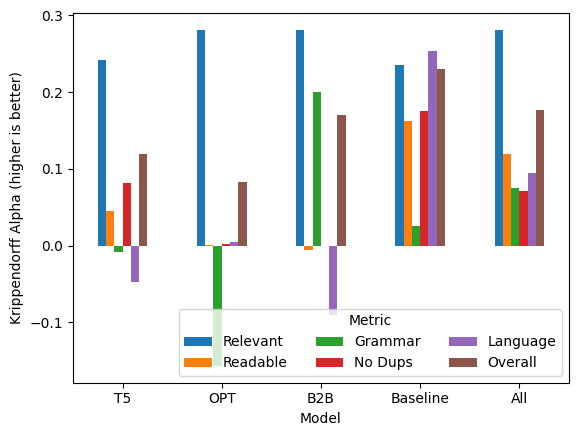

Model,Relevant,Readable,Grammar,No Dups,Language,Overall
T5,0.2418,0.0453,-0.0086,0.0821,-0.0479,0.1193
OPT,0.2811,0.0011,-0.1568,0.0016,0.0045,0.0827
B2B,0.2811,-0.0053,0.1999,-0.0011,-0.0903,0.1705
Baseline,0.2349,0.1619,0.0253,0.1751,0.2538,0.2303
All,0.2808,0.1195,0.0755,0.0711,0.0947,0.1766


In [90]:
display_k_alpha(True)

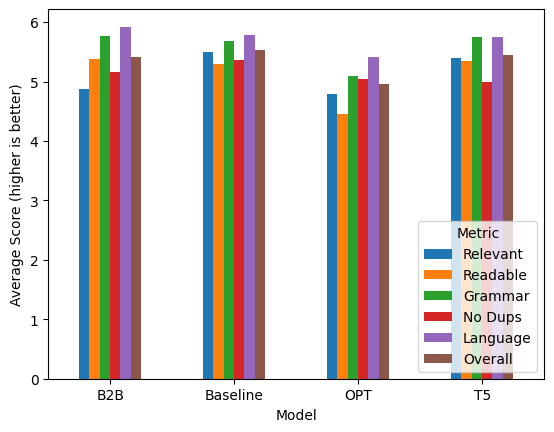

Model,Relevant,Readable,Grammar,No Dups,Language,Overall
B2B,4.8667,5.3778,5.7667,5.1667,5.9222,5.4200
Baseline,5.5000,5.2889,5.6889,5.3556,5.7778,5.5222
OPT,4.7889,4.4556,5.1000,5.0444,5.4111,4.9600
T5,5.4000,5.3444,5.7444,4.9889,5.7556,5.4467


In [91]:
# Plots for human selected entries
display_manual_scores(True)

###Manual Evaluation Scores - Model Selected Entries

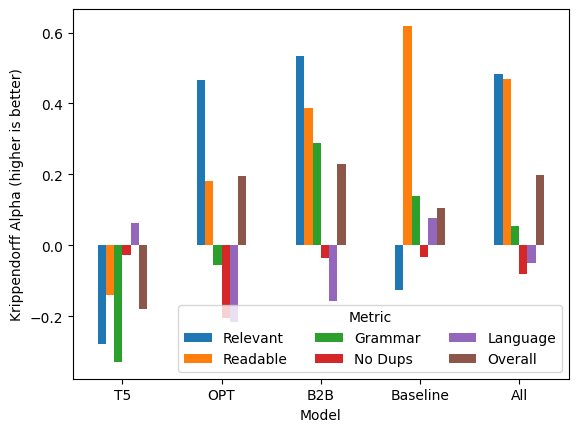

Model,Relevant,Readable,Grammar,No Dups,Language,Overall
T5,-0.2778,-0.1389,-0.3288,-0.0273,0.0622,-0.1802
OPT,0.4665,0.1802,-0.0557,-0.2048,-0.2150,0.1955
B2B,0.5351,0.3886,0.2886,-0.0356,-0.1557,0.2283
Baseline,-0.1250,0.6188,0.1402,-0.0317,0.0778,0.1064
All,0.4833,0.4679,0.0540,-0.0805,-0.0486,0.1970


In [92]:
display_k_alpha(False)

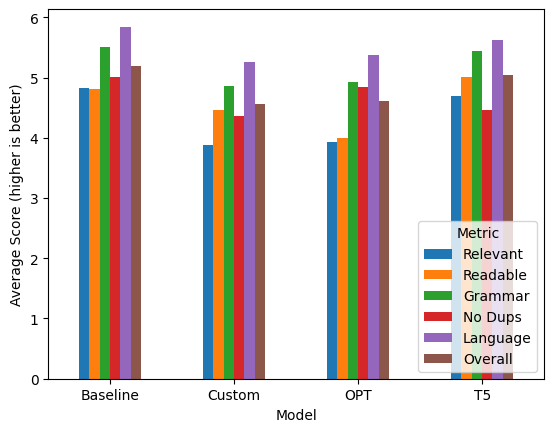

Model,Relevant,Readable,Grammar,No Dups,Language,Overall
Baseline,4.8222,4.8111,5.5000,5.0111,5.8444,5.1978
Custom,3.8889,4.4556,4.8667,4.3556,5.2667,4.5667
OPT,3.9222,3.9889,4.9222,4.8444,5.3778,4.6111
T5,4.6889,5.0111,5.4333,4.4667,5.6222,5.0444


In [81]:
# Plots for model selected entries
display_manual_scores(False)

## Analysis Of Generated Text For Manual Eval

In [95]:
def analysis(human_top_score=True):
  df_annotations = load_annotations(ANNOTATORS, True, human_top_score, annotations_as_cols=True)
  print(df_annotations.columns)
  df_annotations.to_csv('{}manual_row_wise.csv'.format(GDRIVE_BASE), index=None)
  return df_annotations
analysis()

Index(['batch_id', 'name', 'model', 'tuned', 'dataset', 'prompt', 'score',
       'generated', 'model_top_score', 'human_top_score', 'gen_id',
       'annotated', 'A1_relevance', 'A1_readability', 'A1_grammaticality',
       'A1_non-redundancy', 'A1_kid-friendly', 'A1_average_score',
       'A2_relevance', 'A2_readability', 'A2_grammaticality',
       'A2_non-redundancy', 'A2_kid-friendly', 'A2_average_score',
       'A3_relevance', 'A3_readability', 'A3_grammaticality',
       'A3_non-redundancy', 'A3_kid-friendly', 'A3_average_score',
       'friendly_model'],
      dtype='object')


,batch_id,name,model,tuned,dataset,prompt,score,generated,model_top_score,human_top_score,...,A2_non-redundancy,A2_kid-friendly,A2_average_score,A3_relevance,A3_readability,A3_grammaticality,A3_non-redundancy,A3_kid-friendly,A3_average_score,friendly_model
0,1,t5_s3,t5-v1_1-base-s3-finetuned,True,s3,"My stomach did a flip, then a flop, I couldn't...",0.000063,"""Come here, come here!"" cried John.",False,True,...,6,6,5.6,6,6,6,6,6,6.0,T5
2,2,opt_s3,opt-350m-s3-finetuned,True,s3,"My stomach did a flip, then a flop, I couldn't...",0.010260,"My stomach did a flip, then a flop, I couldn't...",True,True,...,5,5,4.0,6,5,6,6,6,5.8,OPT
3,3,b2b_s3,bert2bert_s3_e3_mxlen150,True,s3,"My stomach did a flip, then a flop, I couldn't...",0.736370,""" It ' s all right, "" I said.",False,True,...,5,5,6.0,6,6,6,6,6,6.0,B2B
5,4,baseline,facebook/opt-350m,False,NaN,"My stomach did a flip, then a flop, I couldn't...",0.017674,"My stomach did a flip, then a flop, I couldn't...",False,True,...,6,7,6.0,3,5,5,5,5,4.6,Baseline
8,5,t5_s3,t5-v1_1-base-s3-finetuned,True,s3,One moment Jackson Fickle was taking the secon...,0.000143,"The opening gave way, and in the darkness he s...",False,True,...,5,6,4.6,5,6,6,6,6,5.8,T5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206,116,baseline,facebook/opt-350m,False,NaN,"The man was an alcoholic, and had been drinkin...",0.001157,"The man was an alcoholic, and had been drinkin...",False,True,...,3,5,3.8,3,3,3,4,5,3.6,Baseline
208,117,t5_s3,t5-v1_1-base-s3-finetuned,True,s3,Do you think my mom will let me have pizza for...,0.000228,I don't know whether she will allow me to have...,False,True,...,3,5,5.0,1,6,6,1,6,4.0,T5
210,118,opt_s3,opt-350m-s3-finetuned,True,s3,Do you think my mom will let me have pizza for...,0.003171,Do you think my mom will let me have pizza for...,False,True,...,5,5,4.6,6,6,6,6,6,6.0,OPT
212,119,b2b_s3,bert2bert_s3_e3_mxlen150,True,s3,Do you think my mom will let me have pizza for...,0.883683,I ' m hungry.,False,True,...,6,7,6.0,3,6,6,6,6,5.4,B2B
